In [1]:
import pyomo.environ as pyo
import pyomo.gdp as gdp
import numpy as np
import pandas as pd
import math 
import os, sys
from scipy.stats import multivariate_normal

from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,7)
from enum import Enum

CURRENT_DIR = os.path.dirname(os.path.abspath("rare_pattern_detect"))
sys.path.append(os.path.dirname(CURRENT_DIR))

from rare_pattern_detect.patterns import PatternSpace, PatternSpaceType, MIN_AREA
from rare_pattern_detect.minlp_based import minlp_has_rare_pattern
from rare_pattern_detect.rare_pattern_detect import RarePatternDetect
from rare_pattern_detect.pattern_space_utils import draw_largest_bounding_area, draw2dpattern

# Notes: 
    # There is still an error that happens when the minlp model is not able to solve the problem -> should never return None as a prediction
        # -> can be fixed by setting a very small min_area, which eventually lead to all points being labeled as anomaleous.
    # honestly maybe a circle in 2D (sphere in 3D) as a pattern might make more sense of this 
    # min_area is obviously still a problem 
        # -> need to find a way how to calculate the 4 different variables

# Ongoing: 
    - calculate min area of the cardio dataset -> depends on the pac parameter and the number of training datapoints -> with wolfram we get 41.xx for 100 points, epsilon=0.1 and delta=0.1 
    - calculating the minimum number
    - runnin the minlp solver on the first two features of the cardio data -> minlp solver works  
    - running the minlp solver on all the features of the cardio data -> minlp solver does not work -> internal solver error (cannot recover) ? 
    - running the minlp solver on just three features of the cardio data -> minlp solver does not work -> interval_lengths error

# Process: 
    - TODO: shuffle data points before split to training and testing sets
    - compare performance to SVM, RF using the metrics for supervised learning

# TODO:
    - Done: Create new branch (3D extension)
    - Done: transfer to python files and call the model through the RarePatternDetect(.ipynb -> .py)
    - Done: check if the tests run successfully
    - Done: Rewrite the notebook using the imports 
    - Create a single 3D test (cube)


In [2]:
# MIN_AREA = 0.3 # 0.3

In [3]:
# cmap = plt.get_cmap('viridis')

# training_set =  np.array(
#     [[0.0, 0.0], [2.0, 0.0], [0.0, 2.0], [2.0, 2.0]]
# )
# training_set = multivariate_normal.rvs(size=(20,2))
# point_to_be_classified = np.array([[0.25,0.25]])
# testing_set = multivariate_normal.rvs(size=(3,2))

# os.listdir('../ADbench-main/datasets/Classical')
# b = np.load('../ADbench-main/datasets/Classical/6_cardio.npz')
# b.keys()
# print(b.files)

with np.load('../../ADBench/datasets/Classical/6_cardio.npz') as data:
    X = data['X']
    y = data['y']
    idx = np.random.permutation(len(X))
    X,y = X[idx], y[idx]

#  number of points is 1831
print("number of datapoints is: ",len(y))

# number of feature per data point is 21
print("number of feature per data point is: ", len(X[0]))


TRAINING_LIMIT = 200
TESTING_LIMIT = 10
FEATURES = 2

X = X[:TRAINING_LIMIT+TESTING_LIMIT,:FEATURES]
y = y[:TRAINING_LIMIT+TESTING_LIMIT]

training_set = X[:TRAINING_LIMIT]
training_labels = y[:TRAINING_LIMIT]

testing_set = X[TRAINING_LIMIT:-1]
testing_labels = y[TRAINING_LIMIT:-1]

number of datapoints is:  1831
number of feature per data point is:  21


In [4]:
testing_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0])

---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html


min_area:  1
N=200 , d=2, vc=4
------- itr: 0 -------


Original model has 1811 constraints (1 nonlinear) and 0 disjunctions, with 1006 variables, of which 1000 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP       4.02024e-07            inf    4.02024e-07      nan%      0.49


    functionality.  (deprecated in 6.4.2) (called from
    /Users/p390943/miniforge3/envs/pac_learning/lib/python3.8/site-
    packages/pyomo/contrib/mindtpy/initialization.py:154)


         1              MILP        3.9614e-07            inf    4.02024e-07      nan%      0.97
NLP subproblem was locally infeasible.
Solving feasibility problem
         2              MILP       5.81002e-07            inf    5.81002e-07      nan%      1.79
NLP subproblem was locally infeasible.
Solving feasibility problem
         3              MILP       7.49568e-07            inf    7.49568e-07      nan%      2.84
NLP subproblem was locally infeasible.
Solving feasibility problem
         4              MILP             13.31            inf          13.31      nan%      4.21
*        4         Fixed NLP           1.93787        1.93787          13.31   -586.83%      4.51
MindtPy exiting on bound convergence. Absolute gap: -11.372111332837262 <= absolute tolerance: 0.0001 

 Primal integral          :    0.0000 
 Dual integral            :   37.7806 
 Primal-dual gap integral :   37.7806 


Classification result:  False
area_calculated_pattern:  1.032058316660128


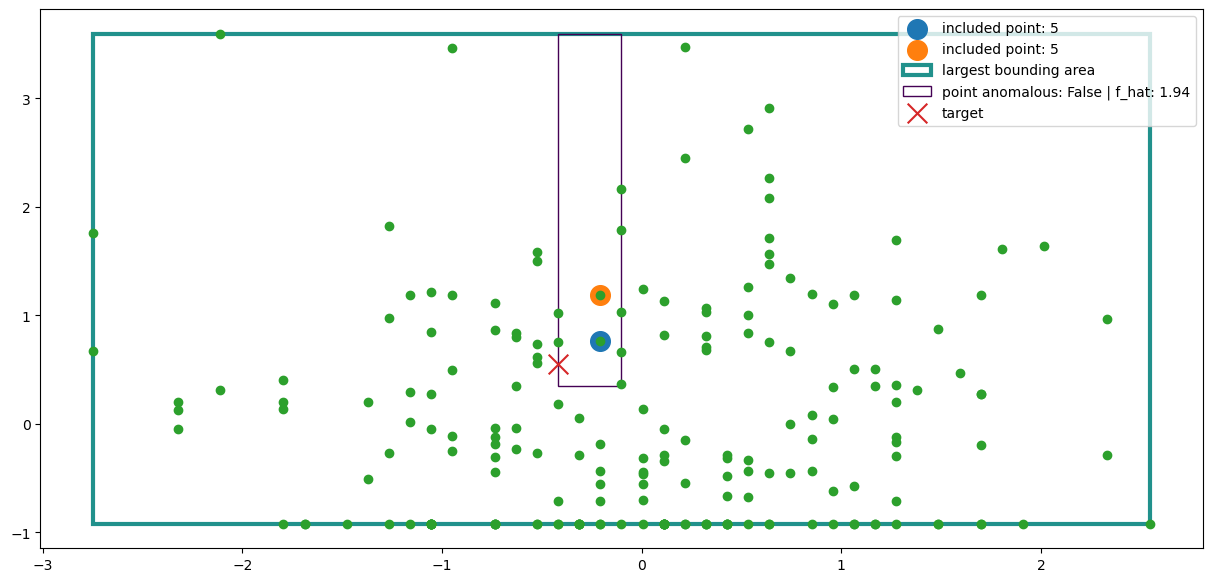

------- itr: 1 -------
ERROR: Unable to clone Pyomo component attribute. Component
    'enforce_point_right_of_pattern_index' contains an uncopyable field
    '_init_dimen' (<class 'pyomo.core.base.initializer.ConstantInitializer'>).
    Setting field to `None` on new object


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 1811 constraints (1 nonlinear) and 0 disjunctions, with 1006 variables, of which 1000 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP       4.06522e-07            inf    4.06522e-07      nan%      0.46
         1              MILP       4.09722e-07            inf    4.09722e-07      nan%      0.58
NLP subproblem was locally infeasible.
Solving feasibility problem
  

Classification result:  False
area_calculated_pattern:  1.0281558130790192


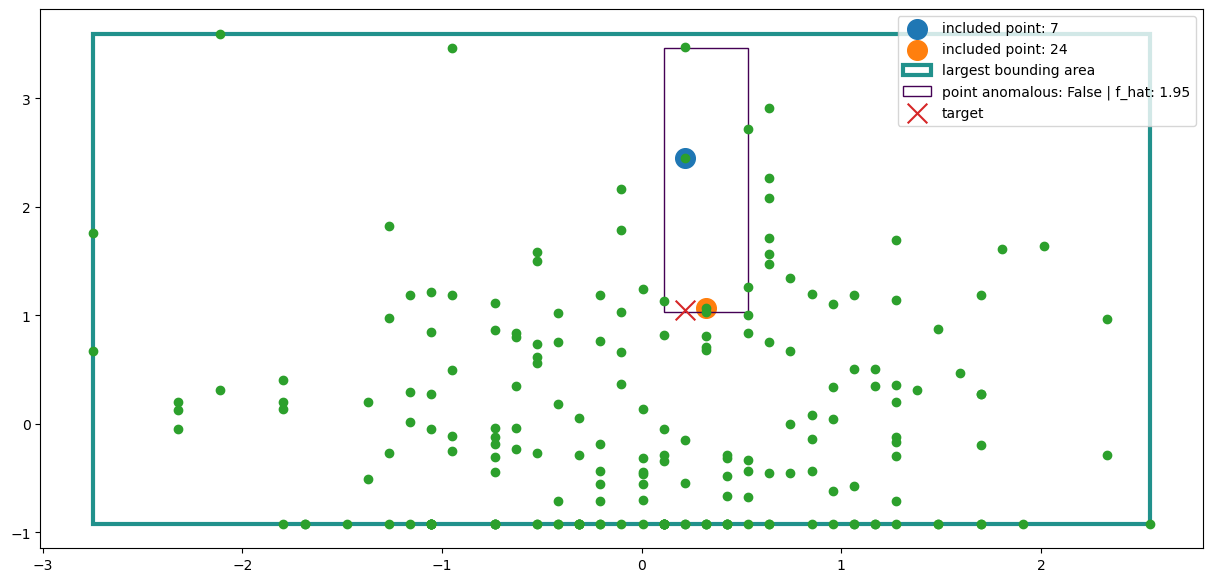

------- itr: 2 -------
ERROR: Unable to clone Pyomo component attribute. Component
    'enforce_point_right_of_pattern_index' contains an uncopyable field
    '_init_dimen' (<class 'pyomo.core.base.initializer.ConstantInitializer'>).
    Setting field to `None` on new object


---------------------------------------------------------------------------------------------
              Mixed-Integer Nonlinear Decomposition Toolbox in Pyomo (MindtPy)               
---------------------------------------------------------------------------------------------
For more information, please visit https://pyomo.readthedocs.io/en/stable/contributed_packages/mindtpy.html
Original model has 1811 constraints (1 nonlinear) and 0 disjunctions, with 1006 variables, of which 1000 are binary, 0 are integer, and 6 are continuous.
Objective is nonlinear. Moving it to constraint set.
rNLP is the initial strategy being used.

 Iteration | Subproblem Type | Objective Value | Primal Bound |   Dual Bound |   Gap   | Time(s)

         -       Relaxed NLP       4.08888e-07            inf    4.08888e-07      nan%      0.48
         1              MILP       4.02427e-07            inf    4.08888e-07      nan%      0.65
NLP subproblem was locally infeasible.
Solving feasibility problem
  

In [ ]:
points_outside_of_largest_bounding_area = 0
indeces = []
predictions = []

mu, epsilon, delta = 0.1, 0.1, 0.1
N, d = training_set.shape
v = 2 * d 
min_area = MIN_AREA 
print("min_area: ", min_area)
print(f"N={N} , d={d}, vc={v}")

lba = np.zeros((d,2), dtype=float)
for i in np.arange(0,d,1):
    lba[i] = np.array(
        [np.min(training_set[:, i]), np.max(training_set[:, i])]
    )

for i, point_to_be_classified in enumerate(testing_set):
    ## 
    print(f"------- itr: {i} -------")

    pattern_space =  PatternSpace(
        type = PatternSpaceType.AXIS_ALIGNED_HYPER_RECTANGLES, 
        cutoff = min_area if min_area != None else 0.1
    )
    
    minlp_model, classification_result = minlp_has_rare_pattern(
        point_to_be_classified,
        training_set,
        pattern_space,
        mu,
        debugging_minlp_model=True,
    )
    
    print("Classification result: ",classification_result)
    predictions.append(classification_result)
    
    ax = plt.gca()
    if minlp_model is not None:
        result = (
            mu,
            classification_result,
            minlp_model
        )
        included_points = minlp_model.extract_points_included_in_pattern()
        calculated_pattern = minlp_model.extract_pattern()
        area_calculated_pattern = np.prod(np.apply_along_axis(lambda i: i[1] - i[0], axis=1, arr=calculated_pattern))
        print("area_calculated_pattern: ", area_calculated_pattern)
        # assert area_calculated_pattern is not None, "area of minimized pattern is None"
        # assert area_calculated_pattern >= 0, "area of minimized pattern is negative"
        largest_bounding_area = minlp_model.largest_bounding_area
        [plt.scatter(
            x=p[0], 
            y=p[1], 
            marker="o", 
            s=200, 
            label=f"included point: {np.argwhere(training_set == p)[0,0]}") for _, p in enumerate(included_points)
        ]
        plt.legend([f"area of calculated pattern: {area_calculated_pattern}"])
        draw_largest_bounding_area(largest_bounding_area, ax)
        draw2dpattern(calculated_pattern, ax, classification_result, minlp_model.minimized_f_hats, len(training_set))
        plt.legend(bbox_to_anchor=(1.1, 1.1))
    else:
        print(f"---> !! minlp model is none and classification results: {classification_result} !! ")
        draw_largest_bounding_area(lba, ax)
        ax.legend()
        points_outside_of_largest_bounding_area += 1 
        indeces.append(i)

    plt.scatter(x=training_set[:,0], y=training_set[:,1])
    plt.scatter(
        x=point_to_be_classified[0], 
        y=point_to_be_classified[1], 
        marker="x",  
        s=200, 
        label="target") 
    plt.legend()
    plt.show()

print("-- END __")
print("Points that lie outside of the largest bounding area defined by the training set: ",points_outside_of_largest_bounding_area) 
print("indices of the points: ", indeces)

# Testing RarePatternDetect class

In [ ]:
# # print(training_set)

# rpd = RarePatternDetect(
#     delta=0.01,
#     tau=0.01,
#     epsilon=0.01,
#     pattern_space = PatternSpace(
#         PatternSpaceType.AXIS_ALIGNED_HYPER_RECTANGLES, 
#         cutoff = 0.41 # 3 #min_area
#     )
# )
# rpd.load_training_data(training_set)
# preds = [rpd.is_anomalous(point_to_be_classified) for _, point_to_be_classified in enumerate(testing_set)]
# print(preds)

# print(predictions)
# # -> should get the same results
# assert preds == predictions
# # ssert preds in np.array([True, False]) and no "None"
# assert None not in preds 
# assert None not in predictions

# Experiment: Prediction using Isolation Forest and comparison with the minlp solver

In [ ]:
# from sklearn.ensemble import IsolationForest

# X = training_set
# clf = IsolationForest(random_state=0).fit(X)
# r = clf.predict(testing_set) # -1 anomalie
# r = np.where(r==1, r, False).astype(bool)
# print("r: ",r)

# count_similar_predictions = np.count_nonzero(r == preds)
# per_similar_predictions = count_similar_predictions/len(testing_set)
# count_similar_predictions,  per_similar_predictions


# Testing the solver on more than two features

In [ ]:
with np.load('../ADbench-main/datasets/Classical/6_cardio.npz') as data:
    X = data['X']
    y = data['y']

TRAINING_LIMIT = 200
TESTING_LIMIT = 5
FEATURES = 2

X = X[:,:FEATURES]

training_set = X[:TRAINING_LIMIT]
training_labels = y[:TRAINING_LIMIT]

# slicing
testing_set = X[TRAINING_LIMIT:-1:300]
testing_labels = y[TRAINING_LIMIT:-1:300]

rpd = RarePatternDetect(
    delta=0.1,
    tau=0.1,
    epsilon=0.1,
    pattern_space = PatternSpace(
        PatternSpaceType.AXIS_ALIGNED_HYPER_RECTANGLES, 
        cutoff = 0.1
    )
)

# print("testing_set: ", testing_set)
rpd.fit(training_set)

preds = [rpd.predict_score(point_to_be_classified) for _, point_to_be_classified in enumerate(testing_set)]

print("--- RESULTS ---")
print("predictions: ", preds)